# Variational Autoencoders with Keras and MNIST
Authors: Charles Kenneth Fisher, Raghav Kansal

Adapted from [this notebook](https://github.com/drckf/mlreview_notebooks/blob/master/jupyter_notebooks/notebooks/NB19_CXVII-Keras_VAE_MNIST.ipynb).

## Learning Goals
The goals of this notebook is to learn how to code a variational autoencoder in Keras. We will discuss hyperparameters, training, and loss-functions. In addition, we will familiarize ourselves with the Keras sequential GUI as well as how to visualize results and make predictions using a VAE with a small number of latent dimensions.

## Overview

This notebook teaches the reader how to build a Variational Autoencoder (VAE) with Keras. The code is a minimally modified, stripped-down version of the code from Lous Tiao in his wonderful [blog post](http://tiao.io/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/) which the reader is strongly encouraged to also read.

Our VAE will have Gaussian Latent variables and a Gaussian Posterior distribution $q_\phi({\mathbf z}|{\mathbf x})$ with a diagonal covariance matrix. 

Recall, that a VAE consists of four essential elements:

* A latent variable ${\mathbf z}$ drawn from a distribution $p({\mathbf z})$ which in our case will be a Gaussian with mean zero and standard
deviation $\epsilon$.
* A decoder $p(\mathbf{x}|\mathbf{z})$ that maps latent variables ${\mathbf z}$ to visible variables ${\mathbf x}$. In our case, this is just a Multi-Layer Perceptron (MLP) - a neural network with one hidden layer.
* An encoder $q_\phi(\mathbf{z}|\mathbf{x})$ that maps examples to the latent space. In our case, this map is just a Gaussian with means and variances that depend on the input: $q_\phi({\bf z}|{\bf x})= \mathcal{N}({\bf z}, \boldsymbol{\mu}({\bf x}), \mathrm{diag}(\boldsymbol{\sigma}^2({\bf x})))$
* A cost function consisting of two terms: the reconstruction error and an additional regularization term that minimizes the KL-divergence between the variational and true encoders. Mathematically, the reconstruction error is just the cross-entropy between the samples and their reconstructions. The KL-divergence term can be calculated analytically for this term and can be written as

$$-D_{KL}(q_\phi({\bf z}|{\bf x})|p({\bf z}))={1 \over 2} \sum_{j=1}^J \left (1+\log{\sigma_j^2({\bf x})}-\mu_j^2({\bf x}) -\sigma_j^2({\bf x})\right).
$$


![VAE](https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png)

## Importing Data and specifying hyperparameters

In the next section of code, we import the data and specify hyperparameters. The MNIST data are gray scale ranging in values from 0 to 255 for each pixel. We normalize this range to lie between 0 and 1. 

The hyperparameters we need to specify the architecture and train the VAE are:

* The dimension of the hidden layers for encoders and decoders (`intermediate_dim`)
* The dimension of the latent space (`latent_dim`)
* The standard deviation of latent variables (`epsilon_std`)
* Optimization hyper-parameters: `batch_size`, `epochs`


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, InputLayer, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
import tensorflow.compat.v1 as tf
import pandas as pd

tf.disable_v2_behavior()

# Load Data and map gray scale 256 to number between zero and 1
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255.0
x_test = np.expand_dims(x_test, axis=-1) / 255.0

print(x_train.shape)

# Find dimensions of input images
img_rows, img_cols, img_chns = x_train.shape[1:]

# Specify hyperparameters
original_dim = img_rows * img_cols
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 10
epsilon_std = 1.0

2023-08-10 21:16:06.549285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
(60000, 28, 28, 1)


## Specifying the loss function

Here we specify the loss function. The first block of code is just the reconstruction error which is given by the cross-entropy. The second block of code calculates the KL-divergence analytically and adds it to the loss function with the line `self.add_loss`. It represents the KL-divergence as just another layer in the neural network with the inputs equal to the outputs: the means and variances for the variational encoder (i.e. $\boldsymbol{\mu}({\bf x})$ and $\boldsymbol{\sigma}^2({\bf x})$).

In [2]:
def nll(y_true, y_pred):
    """Negative log likelihood (Bernoulli)."""

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs

        kl_batch = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

# Encoder and Decoder

The following specifies both the encoder and decoder. The encoder is a MLP with three layers that maps ${\bf x}$ to $\boldsymbol{\mu}({\bf x})$ and $\boldsymbol{\sigma}^2({\bf x})$, followed by the generation of a latent variable using the reparametrization trick (see main text). The decoder is specified as a single sequential Keras layer.


In [3]:
# Encoder

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation="relu")(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

# Reparametrization trick
z_sigma = Lambda(lambda t: K.exp(0.5 * t))(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

# This defines the Encoder which takes noise and input and outputs
# the latent variable z
encoder = Model(inputs=[x, eps], outputs=z)

# Decoder is MLP specified as single Keras Sequential Layer
decoder = Sequential(
    [
        Dense(intermediate_dim, input_dim=latent_dim, activation="relu"),
        Dense(original_dim, activation="sigmoid"),
    ]
)

x_pred = decoder(z)

## Training the model

We now train the model. Even though the loss function is the negative log likelihood (cross-entropy), recall that the KL-layer adds the analytic form of the loss function as well. We also have to reshape the data to make it a vector, and specify an optimizer.

In [4]:
vae = Model(inputs=[x, eps], outputs=x_pred, name="vae")
vae.compile(optimizer="rmsprop", loss=nll)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 2)                    514       ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 2)                    514       ['dense[0][0]']               
                                                                                                

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.0
x_test = x_test.reshape(-1, original_dim) / 255.0

hist = vae.fit(
    x_train,
    x_train,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test),
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
  100/60000 [..............................] - ETA: 1:37 - loss: 544.2440

2023-08-10 21:16:53.858527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-08-10 21:16:53.880792: W tensorflow/c/c_api.cc:304] Operation '{name:'training/RMSprop/dense_1/kernel/rms/Assign' id:413 op device:{requested: '', assigned: ''} def:{{{node training/RMSprop/dense_1/kernel/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/RMSprop/dense_1/kernel/rms, training/RMSprop/dense_1/kernel/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


59600/60000 [============================>.] - ETA: 0s - loss: 190.5041

/Users/raghav/mambaforge/envs/machine-learning-hats-2023/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-10 21:16:56.476440: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/AddN' id:175 op device:{requested: '', assigned: ''} def:{{{node loss/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, kl_divergence_layer/Mean)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


60000/60000 [==============================] - 3s 47us/sample - loss: 190.3902 - val_loss: 171.6324
Epoch 2/10
60000/60000 [==============================] - 3s 48us/sample - loss: 169.5730 - val_loss: 168.1042
Epoch 3/10
60000/60000 [==============================] - 3s 54us/sample - loss: 166.4132 - val_loss: 165.6945
Epoch 4/10
60000/60000 [==============================] - 4s 59us/sample - loss: 164.0100 - val_loss: 163.2361
Epoch 5/10
60000/60000 [==============================] - 4s 64us/sample - loss: 162.1066 - val_loss: 161.7771
Epoch 6/10
60000/60000 [==============================] - 4s 71us/sample - loss: 160.5613 - val_loss: 160.3140
Epoch 7/10
60000/60000 [==============================] - 5s 76us/sample - loss: 159.3625 - val_loss: 158.9860
Epoch 8/10
60000/60000 [==============================] - 5s 84us/sample - loss: 158.4104 - val_loss: 158.6318
Epoch 9/10
60000/60000 [==============================] - 5s 84us/sample - loss: 157.6924 - val_loss: 157.8303
Epoch 10/10


## Visualizing the loss function

We can automatically visualize the loss function as a function of the epoch using the standard Keras interface for fitting. 

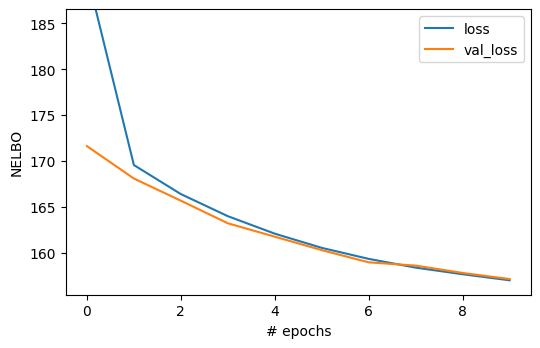

In [6]:
%matplotlib inline

# for pretty plots
golden_size = lambda width: (width, 2.0 * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel("NELBO")
ax.set_xlabel("# epochs")

ax.set_ylim(0.99 * hist_df[1:].values.min(), 1.1 * hist_df[1:].values.max())
plt.show()

## Visualizing embedding in latent space

Since our latent space is two dimensional, we can think of our encoder as defining a dimensional reduction of the original 784 dimensional space to just two dimensions! We can visualize the structure of this mapping by plotting the MNIST dataset in the latent space, with each point colored by which number it is $[0,1,\ldots,9]$.

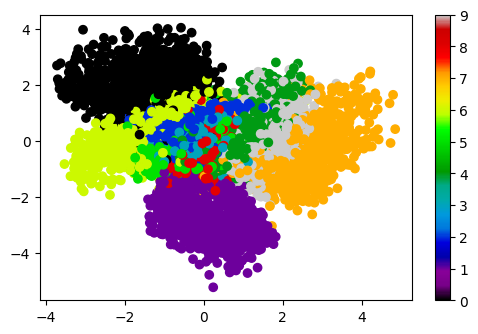

In [8]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=golden_size(6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap="nipy_spectral")
plt.colorbar()
plt.show()

## Generating new examples

One of the nice things about VAEs is that they are generative models. Thus, we can generate new examples.

* Sampling uniformally in the latent space 
* Sampling accounting for the fact that the latent space is Gaussian so that we expect most of the data points to be centered around (0,0) and fall off exponentially in all directions. This is done by transforming the uniform grid using the inverse Cumulative Distribution Function (CDF) for the Gaussian.



/Users/raghav/mambaforge/envs/machine-learning-hats-2023/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-10 21:17:51.062884: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_4/Sigmoid' id:137 op device:{requested: '', assigned: ''} def:{{{node dense_4/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_4/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


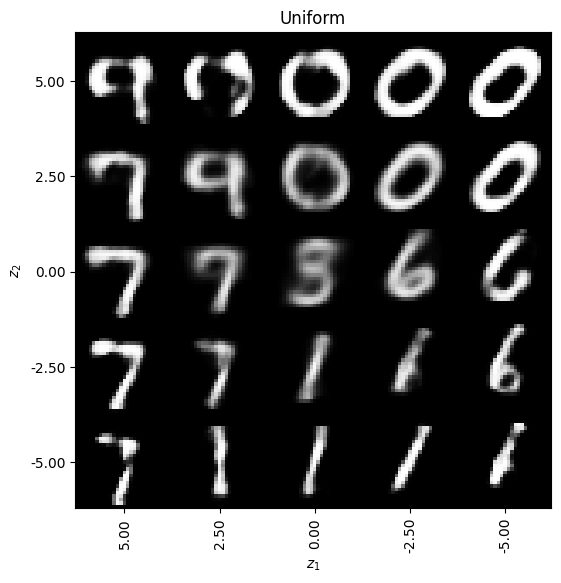

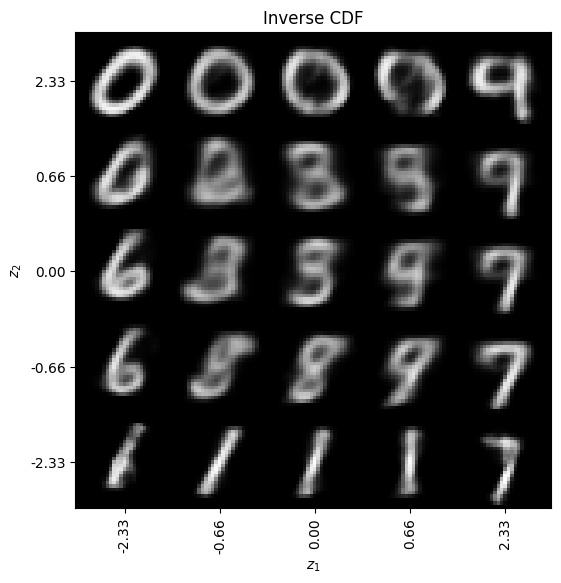

In [9]:
# display a 2D manifold of the images
n = 5  # figure with 15x15 images
quantile_min = 0.01
quantile_max = 0.99

# Linear Sampling
# we will sample n points within [-15, 15] standard deviations
z1_u = np.linspace(5, -5, n)
z2_u = np.linspace(5, -5, n)
z_grid = np.dstack(np.meshgrid(z1_u, z2_u))

x_pred_grid = decoder.predict(z_grid.reshape(n * n, latent_dim)).reshape(n, n, img_rows, img_cols)

# Plot figure
fig, ax = plt.subplots(figsize=golden_size(10))

ax.imshow(np.block(list(map(list, x_pred_grid))), cmap="gray")

ax.set_xticks(np.arange(0, n * img_rows, img_rows) + 0.5 * img_rows)
ax.set_xticklabels(map("{:.2f}".format, z1_u), rotation=90)

ax.set_yticks(np.arange(0, n * img_cols, img_cols) + 0.5 * img_cols)
ax.set_yticklabels(map("{:.2f}".format, z2_u))

ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")
ax.set_title("Uniform")
ax.grid(False)


plt.savefig("VAE_MNIST_fantasy_uniform.pdf")
plt.show()

# Inverse CDF sampling
z1 = norm.ppf(np.linspace(quantile_min, quantile_max, n))
z2 = norm.ppf(np.linspace(quantile_max, quantile_min, n))
z_grid2 = np.dstack(np.meshgrid(z1, z2))

x_pred_grid2 = decoder.predict(z_grid2.reshape(n * n, latent_dim)).reshape(n, n, img_rows, img_cols)

# Plot figure Inverse CDF sampling
fig, ax = plt.subplots(figsize=golden_size(10))

ax.imshow(np.block(list(map(list, x_pred_grid2))), cmap="gray")

ax.set_xticks(np.arange(0, n * img_rows, img_rows) + 0.5 * img_rows)
ax.set_xticklabels(map("{:.2f}".format, z1), rotation=90)

ax.set_yticks(np.arange(0, n * img_cols, img_cols) + 0.5 * img_cols)
ax.set_yticklabels(map("{:.2f}".format, z2))

ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")
ax.set_title("Inverse CDF")
ax.grid(False)
plt.savefig("VAE_MNIST_fantasy_invCDF.pdf")
plt.show()

## Exercises

* Play with the standard deviation of the latent variables $\epsilon$. How does this effect your results?
* Generate samples as you increase the number of latent dimensions. Do your generated samples look better? Visualize the latent variables using a dimensional reduction technique such as PCA or t-SNE. How does it compare to the case with two latent dimensions showed above?
* Repeat this analysis with the W tagging dataset.